# Modeling - Transfer Learning Fine Tuning

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3
import ssl

ssl._create_default_https_context = ssl._create_unverified_context # for downloading weights

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv("train.csv")

In [4]:
base_path = "drive/MyDrive/data"

In [5]:
project_drive_folder = "drive/MyDrive/ML_Project"

In [6]:
df["image_path"] = base_path + "/raw/" + df["image_file_name"]

In [7]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lession_type,lession_type_id,image_file_name,image_path
0,HAM_0005854,ISIC_0025926,nv,histo,60.0,female,back,Melanocytic nevi,4,ISIC_0025926.jpg,drive/MyDrive/data/raw/ISIC_0025926.jpg
1,HAM_0003214,ISIC_0028745,nv,follow_up,60.0,female,foot,Melanocytic nevi,4,ISIC_0028745.jpg,drive/MyDrive/data/raw/ISIC_0028745.jpg
2,HAM_0005577,ISIC_0028320,nv,follow_up,40.0,male,trunk,Melanocytic nevi,4,ISIC_0028320.jpg,drive/MyDrive/data/raw/ISIC_0028320.jpg
3,HAM_0006869,ISIC_0033207,nv,histo,45.0,female,back,Melanocytic nevi,4,ISIC_0033207.jpg,drive/MyDrive/data/raw/ISIC_0033207.jpg
4,HAM_0002409,ISIC_0028843,nv,histo,35.0,female,back,Melanocytic nevi,4,ISIC_0028843.jpg,drive/MyDrive/data/raw/ISIC_0028843.jpg


### Constants

In [8]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=64
EPOCHS = 20

### Train Validation Split 

In [9]:
train_df, validation_df = train_test_split(df, test_size=0.15, stratify=df["lession_type"], random_state=99)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

## Data Augmentation

### Train Image Generator

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6810 validated image filenames belonging to 7 classes.


### Validation Generator

In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    x_col='image_path',
    y_col='lession_type',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1202 validated image filenames belonging to 7 classes.


In [12]:
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]

## Xception

### Callbacks

In [13]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5, min_lr=0.00001)
path_weights = Path( project_drive_folder +'/weights/xception_ft' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

### Build Model

In [14]:
# Xception

base_model = Xception(weights='imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
# base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

# Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [15]:
for layer in base_model.layers:
    layer.trainable = True

### Train

In [16]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
106/106 [==============================] - ETA: 0s - loss: 0.7289 - acc: 0.7415 
Epoch 00001: val_acc improved from -inf to 0.59375, saving model to drive/MyDrive/ML_Project/weights/xception/model_best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


106/106 [==============================] - 1929s 18s/step - loss: 0.7289 - acc: 0.7415 - val_loss: 3.4223 - val_acc: 0.5938 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - ETA: 0s - loss: 0.5477 - acc: 0.8023
Epoch 00002: val_acc improved from 0.59375 to 0.72656, saving model to drive/MyDrive/ML_Project/weights/xception/model_best.hdf5
106/106 [==============================] - 165s 2s/step - loss: 0.5477 - acc: 0.8023 - val_loss: 0.8718 - val_acc: 0.7266 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - ETA: 0s - loss: 0.4677 - acc: 0.8307
Epoch 00003: val_acc did not improve from 0.72656
106/106 [==============================] - 160s 1s/step - loss: 0.4677 - acc: 0.8307 - val_loss: 2.6750 - val_acc: 0.4340 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - ETA: 0s - loss: 0.4071 - acc: 0.8534
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_acc did not improve from 0.72656
106/106 [=

### Export Model

In [17]:
model.save(project_drive_folder +'/weights/xception_ft/model_latest.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Visualize Result

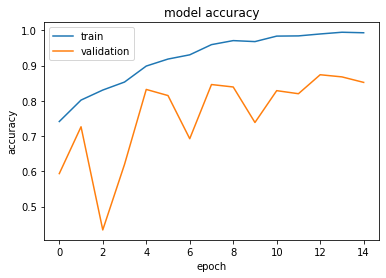

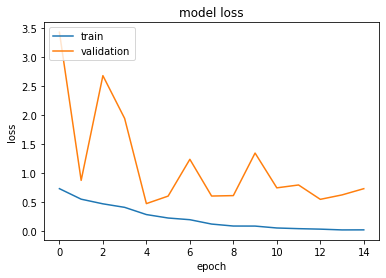

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(project_drive_folder+'/graphs/xception_ft_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(project_drive_folder+'/graphs/xception_ft_model_loss_plot.png')
plt.show()

# Resnet50

## Callbacks

In [19]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5, min_lr=0.00001)
path_weights = Path( project_drive_folder +'/weights/resnet50_ft' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

## Build Model

In [20]:
#ResNet50

base_model = ResNet50(weights='imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
#base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

# Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [21]:
for layer in base_model.layers:
    layer.trainable = True

In [22]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
106/106 [==============================] - ETA: 0s - loss: 0.9104 - acc: 0.6881
Epoch 00001: val_acc improved from -inf to 0.66840, saving model to drive/MyDrive/ML_Project/weights/resnet50/model_best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


106/106 [==============================] - 171s 2s/step - loss: 0.9104 - acc: 0.6881 - val_loss: 2.5372 - val_acc: 0.6684 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - ETA: 0s - loss: 0.7771 - acc: 0.7367
Epoch 00002: val_acc did not improve from 0.66840
106/106 [==============================] - 158s 1s/step - loss: 0.7771 - acc: 0.7367 - val_loss: 1.6291 - val_acc: 0.1102 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - ETA: 0s - loss: 0.7200 - acc: 0.7493
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_acc did not improve from 0.66840
106/106 [==============================] - 156s 1s/step - loss: 0.7200 - acc: 0.7493 - val_loss: 2.4967 - val_acc: 0.0521 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - ETA: 0s - loss: 0.6559 - acc: 0.7763
Epoch 00004: val_acc improved from 0.66840 to 0.67361, saving model to drive/MyDrive/ML_Project/weights/resnet50/model_best.hdf5
106/106 [===

### Export Model

In [23]:
model.save( project_drive_folder + '/weights/resnet50_ft/model_latest.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Visualize Result

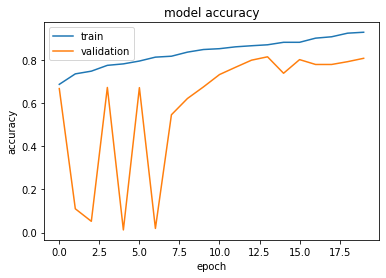

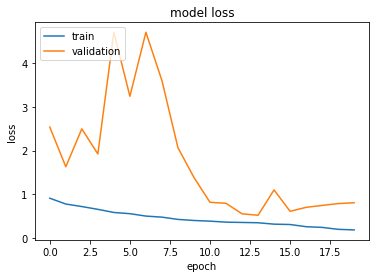

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(project_drive_folder + '/graphs/resnet50_ft_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(project_drive_folder + '/graphs/resnet50_ft_model_loss_plot.png')
plt.show()

## InceptionV3

### Callbacks

In [25]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2,verbose=1,factor=0.5, min_lr=0.00001)
path_weights = Path( project_drive_folder +'/weights/inceptionv3_ft' )
path_weights.mkdir( parents=True, exist_ok=True ) # create a folder for model checkpoints

filepath= os.path.join(path_weights,"model_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

### Build Model

In [26]:
# InceptionV3

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(base_model.input, predictions)

# Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)              

In [27]:
for layer in base_model.layers:
    layer.trainable = True

### Train

In [28]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
106/106 [==============================] - ETA: 0s - loss: 1.1769 - acc: 0.6433
Epoch 00001: val_acc improved from -inf to 0.67969, saving model to drive/MyDrive/ML_Project/weights/inceptionv3/model_best.hdf5
106/106 [==============================] - 165s 2s/step - loss: 1.1769 - acc: 0.6433 - val_loss: 0.8517 - val_acc: 0.6797 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - ETA: 0s - loss: 0.9421 - acc: 0.6857
Epoch 00002: val_acc improved from 0.67969 to 0.69705, saving model to drive/MyDrive/ML_Project/weights/inceptionv3/model_best.hdf5
106/106 [==============================] - 158s 1s/step - loss: 0.9421 - acc: 0.6857 - val_loss: 0.8058 - val_acc: 0.6970 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - ETA: 0s - loss: 0.8926 - acc: 0.6921
Epoch 00003: val_acc improved from 0.69705 to 0.70660, saving model to drive/MyDrive/ML_Project/weights/inceptionv3/model_best.hdf5
106/106 [==============================] - 158s 1s/step - loss: 

### Export Model

In [29]:
model.save( project_drive_folder +'/weights/inceptionv3_ft/model_latest.hdf5')

### Visualize Result

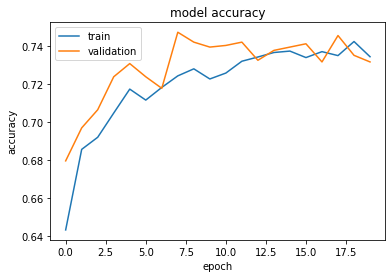

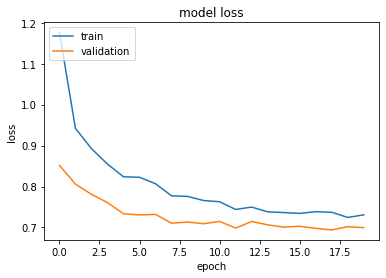

In [30]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(project_drive_folder +'/graphs/inceptionv3_ft_model_accuracy_plot.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(project_drive_folder + '/graphs/inceptionv3_ft_model_loss_plot.png')
plt.show()